# Identifying Fraud from Enron Data

## Objective

This project will use machine learning to attempt to identify persons of interest from the Enron financial scandel. Persons of Interest (POIs) were defined at the onset by Udacity using resource created by USA Today <cite data-cite="6112171/BAJ6H3FC"></cite>. 

Two data resources were identified by Udacity for identifying POIs. The first is the Enron Email Datset maintained by Carnegie Mellon University <cite data-cite="6112171/GLPDFEY4"></cite>. The email dataset contains a corpus of close to 500,000 email messages from Enron's servers. The second is a dataset created by Udacity with a collection of useful information for the task. It contains both financial features as well as aggregate information about the email dataset. 

Machine learning excels at this type of task because it can be used to process large amounts of information in a way that would be time consuming if done by hand. Machine learning algorithms use statistical methods to *learn* from data and can then make inferences based on the relationships they have found. Although developing the algorithms takes considerable amount of care and effort in itself, when completed they can be used to process the entire email dataset within minutes.

### Data Exploration
The data was loaded into a pandas dataframes to simplify exploration and visualization. There were 146 entries in the dataset and 21 features. 18 (12%) of the entries were identified as persons of interest.

I decided to separate the dataset into two data frames for exploration because of its split nature. The financial information came from a document attributed to Findlaw.com. Wheras the email information was compiled by aggregating information form the Enron Email corpus. For this reason it made sense to divide the data when looking for trends and similarities between the features.

### Outlier Investigation

To search for outliers I used the zscore function from scipy. The function normalizes values as a measurement of standard devations from the mean. This makes it easier to analyze values in context to how far they stand out from the rest of the data.  I created a screened for any values with a zscore above 3.

In the first run through finacial data I found 'BHATNAGAR SANJAY', 'LAY KENNETH L',  and 'TOTAL'. The 'TOTAL' entry prompted me to seach through the Findlaw.com document for other unusual items. I also found a travel agency that needed to be removed.

Removing the TOTAL entry affected the zscores and there were now many more outliers. Plotting the data showed that most of the financial features were positively skeweed. This made sense, considering the presense of executives and directors in the data. Their compensation was far beyond the rest of the employess. They also receive unique types of compensation such as restricted stock and director fees which other employees are not paid. These outliers did not represent errors were kept.

The email data had fewer findings. And some outliers were expected. Individuals who regularly contacted POIs stood out from those who didn't because the POIs only make up a small portion of the email corpus. However, the persons who were identified as outliers for non-POI related fields represent a risk in data leakage. I did some searching and confirmed that these individuals held high level positions at Enron. It is likely they had a higher presense in the email corpus because they were the focus of investigations. This created a potential problem where the focus of the investigation could leak in as a factor in identifying POIs.

To counter this I decided to create percentage based representations of the POI features. In this way a classifier cannot know how many total emails are present for a given person in the database.

In [1]:
import pickle
import pandas as pd
import numpy as np

# Load dataset
with open('final_project/final_project_dataset.pkl', 'r') as f:
    data_dict = pickle.load(f)

# Convert to dataframe
df = pd.DataFrame(data_dict).T

# Drop outliers
df.drop(['TOTAL', 'THE TRAVEL AGENCY IN THE PARK'], inplace=True)

# Drop useless column
df.drop('email_address', axis=1, inplace=True)

# Columns can now all be converted to numeric
df = df.applymap(float)

# Add new features
df['bonus_ratio'] = df.bonus / df.salary
df['stock_ratio'] = df.total_stock_value / df.total_payments
df['from_this_person_to_poi_ratio'] = df['from_this_person_to_poi'] / df['from_messages']
df['from_poi_to_this_person_ratio'] = df['from_poi_to_this_person'] / df['to_messages']

In [2]:
for feature,value in df.isnull().sum().iteritems():
    pct_null = value / float(len(df))
    if feature != 'poi' and pct_null > .6:
        print 'Dropping {0}, {1} null'.format(feature, pct_null)
        df.drop(feature, axis=1, inplace=True)

Dropping deferral_payments, 0.736111111111 null
Dropping deferred_income, 0.666666666667 null
Dropping director_fees, 0.888888888889 null
Dropping loan_advances, 0.979166666667 null
Dropping restricted_stock_deferred, 0.881944444444 null


In [3]:
features = df.columns.tolist()
features.remove('poi')
features

['bonus',
 'exercised_stock_options',
 'expenses',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'long_term_incentive',
 'other',
 'restricted_stock',
 'salary',
 'shared_receipt_with_poi',
 'to_messages',
 'total_payments',
 'total_stock_value',
 'bonus_ratio',
 'stock_ratio',
 'from_this_person_to_poi_ratio',
 'from_poi_to_this_person_ratio']

In [4]:
from sklearn.feature_selection import SelectKBest, f_classif

X = df[features].fillna(0)
y = df['poi']

sel = SelectKBest(f_classif)

sel.fit(X, y)

SelectKBest(k=10, score_func=<function f_classif at 0x000000000BE18DD8>)

In [5]:
feature_pvalues = pd.Series(sel.pvalues_, index=features)
feature_pvalues = feature_pvalues[feature_pvalues < .05]
filtered_features = feature_pvalues.index.tolist()
print feature_pvalues
print len(feature_pvalues)

bonus                            0.000010
exercised_stock_options          0.000002
expenses                         0.013673
from_poi_to_this_person          0.022221
long_term_incentive              0.001845
other                            0.041164
restricted_stock                 0.002670
salary                           0.000030
shared_receipt_with_poi          0.003634
total_payments                   0.003403
total_stock_value                0.000002
bonus_ratio                      0.001183
from_this_person_to_poi_ratio    0.000075
dtype: float64
13


In [6]:
df[filtered_features].corr().gt(.9).sum()

bonus                            1
exercised_stock_options          2
expenses                         1
from_poi_to_this_person          1
long_term_incentive              1
other                            1
restricted_stock                 1
salary                           1
shared_receipt_with_poi          1
total_payments                   1
total_stock_value                2
bonus_ratio                      1
from_this_person_to_poi_ratio    1
dtype: int64

In [7]:
filtered_features.remove('total_stock_value')
filtered_features.remove('total_payments')

In [58]:
filtered_features

['bonus',
 'exercised_stock_options',
 'expenses',
 'from_poi_to_this_person',
 'long_term_incentive',
 'other',
 'restricted_stock',
 'salary',
 'shared_receipt_with_poi',
 'bonus_ratio',
 'from_this_person_to_poi_ratio']

In [8]:
feature_pvalues[filtered_features].to_frame().to_html()

u'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>0</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>bonus</th>\n      <td>0.000010</td>\n    </tr>\n    <tr>\n      <th>exercised_stock_options</th>\n      <td>0.000002</td>\n    </tr>\n    <tr>\n      <th>expenses</th>\n      <td>0.013673</td>\n    </tr>\n    <tr>\n      <th>from_poi_to_this_person</th>\n      <td>0.022221</td>\n    </tr>\n    <tr>\n      <th>long_term_incentive</th>\n      <td>0.001845</td>\n    </tr>\n    <tr>\n      <th>other</th>\n      <td>0.041164</td>\n    </tr>\n    <tr>\n      <th>restricted_stock</th>\n      <td>0.002670</td>\n    </tr>\n    <tr>\n      <th>salary</th>\n      <td>0.000030</td>\n    </tr>\n    <tr>\n      <th>shared_receipt_with_poi</th>\n      <td>0.003634</td>\n    </tr>\n    <tr>\n      <th>bonus_ratio</th>\n      <td>0.001183</td>\n    </tr>\n    <tr>\n      <th>from_this_person_to_poi_ratio</th>\n      <td>0.000075

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score

In [51]:
# Build the pipeline and grid search.

pipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('reduce_dim', SelectKBest(f_classif)),
    ('classifier', LinearSVC())
])

n_features = np.arange(1, len(filtered_features)+1)

param_grid = [
    {
        'reduce_dim__k': n_features,
        'classifier': [LinearSVC(), KNeighborsClassifier(n_neighbors=2),
                       DecisionTreeClassifier(), AdaBoostClassifier()],
    }
]

grid = GridSearchCV(pipe, cv=StratifiedShuffleSplit(n_splits=50, random_state=35),
                    param_grid=param_grid, scoring='f1', n_jobs=8)

In [52]:
grid.fit(df[filtered_features].fillna(0), df['poi'])

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=35, test_size='default',
            train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reduce_dim', SelectKBest(k=10, score_func=<function f_classif at 0x000000000BE18DD8>)), ('classifier', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=8,
       param_grid=[{'classifier': [LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), KNeighborsClassifier(algorithm='auto', leaf_size=30, met...tors=50, random_state=None)], 'reduce_dim__k': array([ 1,  2,  3,

In [53]:
grid.best_estimator_

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reduce_dim', SelectKBest(k=9, score_func=<function f_classif at 0x000000000BE18DD8>)), ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])

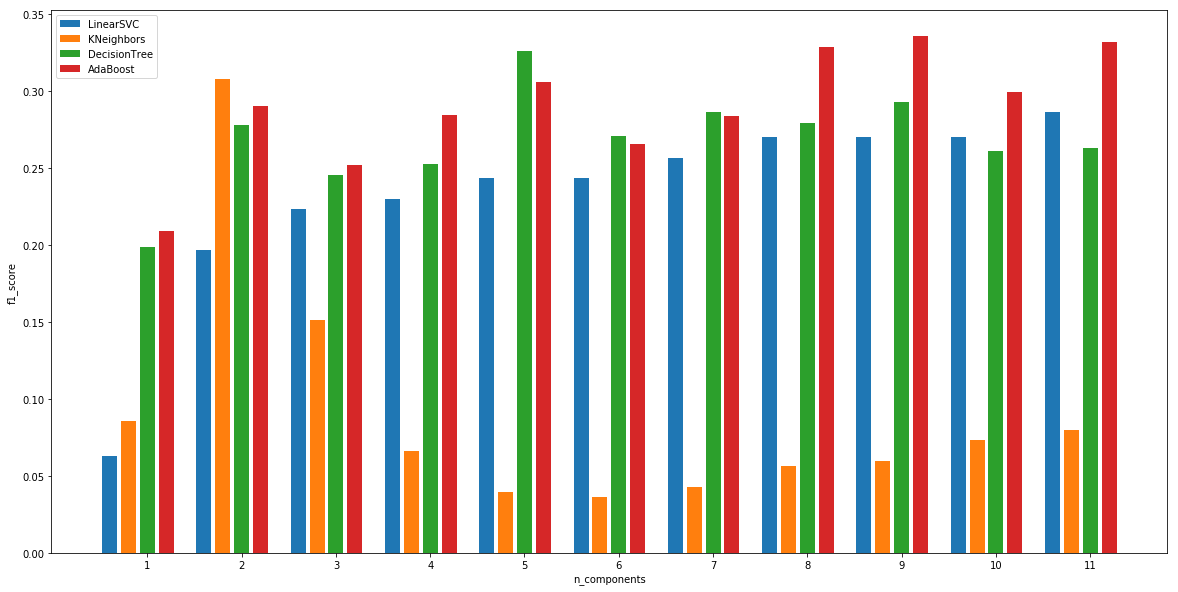

In [54]:
# Plot results
import matplotlib.pyplot as plt
%matplotlib inline

# Labels for the plot legend
classifiers = ['LinearSVC', 'KNeighbors', 'DecisionTree', 'AdaBoost']

# Get scores and reshape them for the zip function
mean_scores = grid.cv_results_['mean_test_score']
mean_scores = mean_scores.reshape(len(classifiers), len(n_features))

bar_offsets = np.arange(len(n_features)) * (len(classifiers)+1) + .5

plt.figure(figsize=(20,10))

for i, (classifier, f1_score) in enumerate(zip(classifiers, mean_scores)):
    plt.bar(bar_offsets + i, f1_score, label=classifier)

plt.title('')

plt.xlabel('n_components')
plt.xticks(bar_offsets + len(classifiers)/2, n_features)

plt.ylabel('f1_score')

plt.legend()
plt.show()

In [55]:
final_features = pd.Series(grid.best_estimator_.named_steps['reduce_dim'].scores_,
          index=filtered_features).nlargest(9).index.tolist()
pd.Series(grid.best_estimator_.named_steps['reduce_dim'].scores_,
          index=filtered_features).nlargest(9).rename('F-value').to_frame()#.to_html()

,F-value
exercised_stock_options,25.097542
bonus,21.060002
salary,18.575703
from_this_person_to_poi_ratio,16.641707
bonus_ratio,10.955627
long_term_incentive,10.072455
restricted_stock,9.346701
shared_receipt_with_poi,8.746486
expenses,6.234201


In [56]:
grid.cv_results_['mean_test_score']

array([ 0.06333333,  0.19666667,  0.22333333,  0.23      ,  0.24333333,
        0.24333333,  0.25666667,  0.27      ,  0.27      ,  0.27      ,
        0.28666667,  0.08571429,  0.308     ,  0.15133333,  0.06666667,
        0.04      ,  0.03666667,  0.04333333,  0.05666667,  0.06      ,
        0.07333333,  0.08      ,  0.19904762,  0.27809524,  0.24533333,
        0.25285714,  0.3257619 ,  0.27104762,  0.28647619,  0.27909524,
        0.29266667,  0.261     ,  0.26333333,  0.20933333,  0.29009524,
        0.25238095,  0.2847619 ,  0.30571429,  0.26580952,  0.284     ,
        0.32866667,  0.336     ,  0.29933333,  0.332     ])

In [57]:
pd.DataFrame(grid.cv_results_['mean_test_score'].reshape(4, -1).max(axis=1),
             index=classifiers, columns=['f1_score'])#.to_html()

,f1_score
LinearSVC,0.286667
KNeighbors,0.308000
DecisionTree,0.325762
AdaBoost,0.336000


In [38]:
tuning_pipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('classify', AdaBoostClassifier())
])

estimators = [50, 40, 30, 20, 10]
learning_rates = [1., .75, .5, .25]

tuning_param_grid = [
    {
        'classify__n_estimators': estimators,
        'classify__learning_rate': learning_rates
    }
]



tuning_grid = GridSearchCV(tuning_pipe, cv=StratifiedShuffleSplit(n_splits=50, random_state=35),
                           param_grid=tuning_param_grid, scoring='f1', n_jobs=8)

In [39]:
tuning_grid.fit(df[final_features].fillna(0), df['poi'])

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=35, test_size='default',
            train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classify', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params=None, iid=True, n_jobs=8,
       param_grid=[{'classify__learning_rate': [1.0, 0.75, 0.5, 0.25], 'classify__n_estimators': [50, 40, 30, 20, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [46]:
tuning_grid.best_estimator_.score(df[final_features].fillna(0), df['poi'])

0.97222222222222221

In [41]:
tuning_grid.cv_results_['mean_test_score'].reshape(4, 5, -1)

array([[[ 0.332     ],
        [ 0.34904762],
        [ 0.33904762],
        [ 0.38333333],
        [ 0.43571429]],

       [[ 0.34638095],
        [ 0.39238095],
        [ 0.35304762],
        [ 0.388     ],
        [ 0.43038095]],

       [[ 0.35171429],
        [ 0.38438095],
        [ 0.38171429],
        [ 0.39171429],
        [ 0.37438095]],

       [[ 0.31304762],
        [ 0.34971429],
        [ 0.37771429],
        [ 0.396     ],
        [ 0.388     ]]])

In [42]:
final_features

['exercised_stock_options',
 'bonus',
 'salary',
 'from_this_person_to_poi_ratio',
 'bonus_ratio',
 'long_term_incentive',
 'restricted_stock',
 'shared_receipt_with_poi',
 'expenses',
 'from_poi_to_this_person',
 'other']

In [ ]:
# Labels for the plot legend
classifiers = ['LinearSVC', 'KNeighbors', 'DecisionTree', 'AdaBoost']

# Get scores and reshape them for the zip function
mean_scores = grid.cv_results_['mean_test_score']
mean_scores = mean_scores.reshape(len(classifiers), len(n_features))

bar_offsets = np.arange(len(n_features)) * (len(classifiers)+1) + .5

plt.figure(figsize=(20,10))

for i, (classifier, f1_score) in enumerate(zip(classifiers, mean_scores)):
    plt.bar(bar_offsets + i, f1_score, label=classifier)

plt.title('')

plt.xlabel('n_components')
plt.xticks(bar_offsets + len(classifiers)/2, n_features)

plt.ylabel('f1_score')

plt.legend()
plt.show()

In [ ]:
financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances','bonus',
                      'restricted_stock_deferred', 'deferred_income', 'total_stock_value',
                      'expenses', 'exercised_stock_options', 'other', 'long_term_incentive',
                      'restricted_stock', 'director_fees']

numeric_email_features = ['to_messages', 'from_poi_to_this_person', 'from_messages',
                           'from_this_person_to_poi', 'shared_receipt_with_poi']
text_email_features = ['email_address']

# Separate the features into 2 dataframes and convert all of the numeric features
financial_data = udacity_data[financial_features].astype(float)
email_data = udacity_data[numeric_email_features].astype(float)

# Non numeric data
email_data[text_email_features] = udacity_data[text_email_features]

# And of course the POI label as a boolean value
financial_data['poi'] = udacity_data['poi'].astype(bool)
email_data['poi'] = udacity_data['poi'].astype(bool)

Only 86 entries remain, with 4 of the persons of interest having been removed. None of the fields have null values.

The proportion of POIs in the email subset of the data is 25% higher than the full dataset. One thing to watch out for  will be an estimator that gives weight to missing email data as a sign that the person is a POI. This will be a difficult overfit to control for, because the way the dataset is constructed splitting the data into training and test sets will maintain this proportional difference. To counter this I plan to impute missing data for any email fields included in the final algorithm.

In [ ]:
email_outliers = return_outliers(email_data[numeric_email_features])
print email_outliers
email_data[numeric_email_features].apply(zscore).loc[email_outliers]

Only three people were found as outliers, none of which were identified as POIs. I plan to test the affects of removing these individuals during the feature and algorithm selection process to see if it increases accuracy.

## Feature and Algorithm Selection

One theory I have is that incidents like the Enron scandal are created by systemic problems within companies. For example, in the case of Enron employee compensation could have been structured in a way that rewarded bad actors.

I created a two new features to search for compensation schemes that might have been used as performance incentives. The idea being that if these incentives are being used to reward the most competitive employees, the 'cheaters' might have risen to the top.
1. Bonus / Salary
    - How large was the bonus in relation to salary?
2. Total Stock Value / Total Payments
    - Did any employees receive large amounts of stock in comparison with more standard compensation payments?

In [ ]:
financial_data['bonus_ratio'] = financial_data.bonus / financial_data.salary
financial_data['stock_ratio'] = financial_data.total_stock_value / financial_data.total_payments 

In [ ]:
combined_data = financial_data.join(email_data.drop('poi', axis=1))

# Remove invalid ratios (divide by 0 = infinite)
combined_data.replace(np.inf, 0, inplace=True)
combined_data.fillna(0, inplace=True)

combined_data.drop('email_address', axis=1, inplace=True)
combined_data.drop('exercised_stock_options', axis=1, inplace=True)
combined_data.drop('restricted_stock', axis=1, inplace=True)
combined_data.drop('total_payments', axis=1, inplace=True)
#combined_data.drop('bonus', axis=1, inplace=True)

features = combined_data.columns.tolist()
features.remove('poi')

In [ ]:
features

I created a pipeline to apply scaling and dimensionality reduction, and used a grid search to choose how many principal components to keep <cite data-cite="6112171/GRUQ2GTK"></cite>. I included multiple algoritms in the grid search to ensure that the results weren't impacted by the limitations of the estimator. This also gave me the chance to start thinking about what algorithm would be my final choice for finding POIs.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score

In [ ]:
# Run the gridsearch
grid.fit(combined_data[features], combined_data['poi'])

In [ ]:
pd.Series(grid.best_estimator_.named_steps['reduce_dim'].pvalues_, index=features).nsmallest(6)

In [ ]:
grid.best_estimator_

## Algorithm Selection




## References
<div class="cite2c-biblio"></div>